# 準備

## Googleドライブのマウント

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [6]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

# minst

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.2
                : 10. 正答率(テスト) = 0.2385
Generation: 20. 正答率(トレーニング) = 0.15
                : 20. 正答率(テスト) = 0.1651
Generation: 30. 正答率(トレーニング) = 0.31
                : 30. 正答率(テスト) = 0.2706
Generation: 40. 正答率(トレーニング) = 0.25
                : 40. 正答率(テスト) = 0.2499
Generation: 50. 正答率(トレーニング) = 0.31
                : 50. 正答率(テスト) = 0.3098
Generation: 60. 正答率(トレーニング) = 0.31
                : 60. 正答率(テスト) = 0.3445
Generation: 70. 正答率(トレーニング) = 0.45
                : 70. 正答率(テスト) = 0.5215
Generation: 80. 正答率(トレーニング) = 0.55
                : 80. 正答率(テスト) = 0.5972
Generation: 90. 正答率(トレーニング) = 0.75
                : 90. 正答率(テスト) = 0.648
Generation: 100. 正答率(トレーニング) = 0.68
                : 100. 正答率(テスト) = 0.6721
Generation: 110. 正答率(トレーニング) = 0.71
                : 110. 正答率(テスト) = 0.6958
Generation: 120. 正答率(トレーニング) = 0.81
                : 120. 正答率(テスト) = 0.7484
Generation: 130. 正答率(トレーニング) = 0.74
                : 130. 正答率(テスト) = 0.7781
Generatio

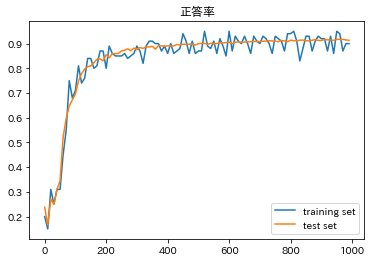

In [19]:
import numpy as np
from data.mnist import load_mnist
import pickle
from common import functions
import matplotlib.pyplot as plt
# !pip install japanize-matplotlib
import japanize_matplotlib

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01 # 変更してみよう
#入力層サイズ
input_layer_size = 784 # 変更してみよう
#中間層サイズ
hidden_layer_size = 40 # 変更してみよう
#出力層サイズ
output_layer_size = 10 # 変更してみよう
# 繰り返し数
iters_num = 1000 # 変更してみよう
# ミニバッチサイズ
batch_size = 100 # 変更してみよ
# 学習率
learning_rate = 0.1 # 変更してみよう
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_size)
    network['W2'] = wieght_init * np.random.randn(hidden_layer_size, output_layer_size)
    # 試してみよう_Xavierの初期値
    # network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size)
    # network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size)
    # 試してみよう Heの初期値
    # network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
    # network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)

    network['b1'] = np.zeros(hidden_layer_size)
    network['b2'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2 = network['W1'], network['W2']
    b1, b2  = network['b1'], network['b2']
        
    u1 =  np.dot(x, W1) + b1
    z1 = functions.relu(u1)
    u2 =  np.dot(z1, W2) + b2
    y = functions.softmax(u2)
 
    return z1, y

# 誤差逆伝播
def backward(x, d, z1, y):
    grad = {}
    
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']    
    # 出力層でのデルタ
    delta2 = functions.d_softmax_with_loss(d, y)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()


accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'b1', 'b2'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("正答率")
# グラフの表示
plt.show()

## 試してみよう（Xavierの初期値）


データ読み込み完了


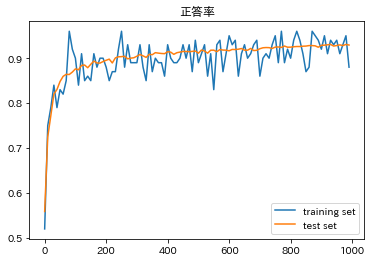

In [18]:
import numpy as np
from data.mnist import load_mnist
import pickle
from common import functions
import matplotlib.pyplot as plt
# !pip install japanize-matplotlib
import japanize_matplotlib

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01 # 変更してみよう
#入力層サイズ
input_layer_size = 784 # 変更してみよう
#中間層サイズ
hidden_layer_size = 40 # 変更してみよう
#出力層サイズ
output_layer_size = 10 # 変更してみよう
# 繰り返し数
iters_num = 1000 # 変更してみよう
# ミニバッチサイズ
batch_size = 100 # 変更してみよ
# 学習率
learning_rate = 0.1 # 変更してみよう
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    # network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_size)
    # network['W2'] = wieght_init * np.random.randn(hidden_layer_size, output_layer_size)
    # 試してみよう_Xavierの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size)
    network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size)
    # 試してみよう Heの初期値
    # network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
    # network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)

    network['b1'] = np.zeros(hidden_layer_size)
    network['b2'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2 = network['W1'], network['W2']
    b1, b2  = network['b1'], network['b2']
        
    u1 =  np.dot(x, W1) + b1
    z1 = functions.relu(u1)
    u2 =  np.dot(z1, W2) + b2
    y = functions.softmax(u2)
 
    return z1, y

# 誤差逆伝播
def backward(x, d, z1, y):
    grad = {}
    
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']    
    # 出力層でのデルタ
    delta2 = functions.d_softmax_with_loss(d, y)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()


accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        # print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        # print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'b1', 'b2'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("正答率")
# グラフの表示
plt.show()

## 試してみよう（Heの初期値）

データ読み込み完了


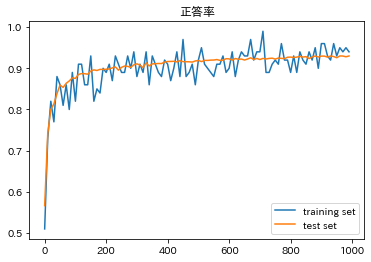

In [20]:
import numpy as np
from data.mnist import load_mnist
import pickle
from common import functions
import matplotlib.pyplot as plt
# !pip install japanize-matplotlib
import japanize_matplotlib

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01 # 変更してみよう
#入力層サイズ
input_layer_size = 784 # 変更してみよう
#中間層サイズ
hidden_layer_size = 40 # 変更してみよう
#出力層サイズ
output_layer_size = 10 # 変更してみよう
# 繰り返し数
iters_num = 1000 # 変更してみよう
# ミニバッチサイズ
batch_size = 100 # 変更してみよ
# 学習率
learning_rate = 0.1 # 変更してみよう
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    # network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_size)
    # network['W2'] = wieght_init * np.random.randn(hidden_layer_size, output_layer_size)
    # 試してみよう_Xavierの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size)
    network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size)
    # 試してみよう Heの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
    network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)

    network['b1'] = np.zeros(hidden_layer_size)
    network['b2'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2 = network['W1'], network['W2']
    b1, b2  = network['b1'], network['b2']
        
    u1 =  np.dot(x, W1) + b1
    z1 = functions.relu(u1)
    u2 =  np.dot(z1, W2) + b2
    y = functions.softmax(u2)
 
    return z1, y

# 誤差逆伝播
def backward(x, d, z1, y):
    grad = {}
    
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']    
    # 出力層でのデルタ
    delta2 = functions.d_softmax_with_loss(d, y)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()


accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        # print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        # print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'b1', 'b2'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("正答率")
# グラフの表示
plt.show()